# Sleeping pills

A pharma company just designed a new pill to help you sleep. They got data, but it doesn't come from a randomized control trial. 

- Does the drug work?
- Does it help people of different ages equally?

We will make use of an S-learner and a T-learner to estimate the drug's conditional treatment effect (CATE), and try to answer those questions rigorously.

Causal Model:
- Treatment (pill): taking or not taking the new med (binary: 0 or 1)
- Outcome (qual): the quality of sleep (continuous)
- Feature/Confounder (age): The age of the subject (discrete)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

RANDOM_STATE = 123
np.random.seed(RANDOM_STATE)

### Define the simulation mechanism

Subjects will be uniformily distributed, centered around 18 years of age.

The medication effect is set to be age-dependent: little to no effect until the age of 40. Then a positive effect, peaking at 70. Followed by reducing effectiveness until the age of 90.

The propensity score defined the bias of the population we observe. Older people are more likely to make use of the drug.

In [2]:
def generate_age(n):
    """Age of the subjects."""
    return np.random.uniform(18, 90, size=n)

def true_cate(age):
    """Define true CATE.
    
    True (nonlinear) CATE: Bell-shaped effect: increases with age up to a point, 
    then decreases. Use a scaled Gaussian centered at age 70, width ~12 years near-zero 
    for young, increasing nonlinearly for older.
    """
    return 1.5 * np.exp(-((age - 70) ** 2) / (2 * 12 ** 2))

def propensity(age):
    """Define prob of being assigned to treatment.

    Slightly confounded by age (older slightly more likely to take medication).
    probability between ~0.2 and ~0.6.
    """
    return 0.05 + 0.4 / (1 + np.exp(-(age - 55) / 10.0))

def measurement_noise(n):
    """Measurement noise."""
    return np.random.normal(scale=0.3, size=n)

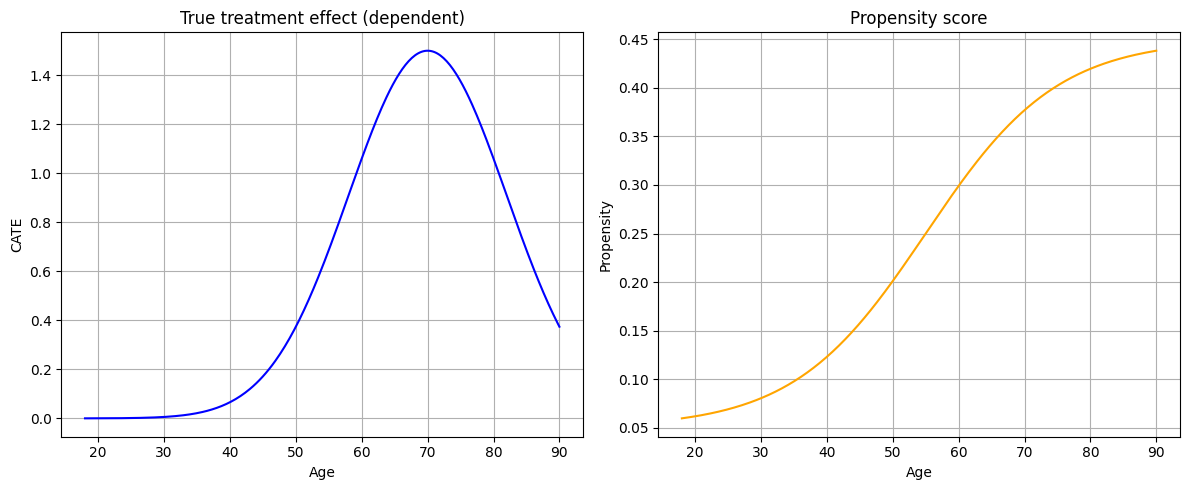

In [3]:
# Visualize the true relationships

ages = np.linspace(18, 90, 300)
true_effects = true_cate(ages)
propensities = propensity(ages)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ages, true_effects, label="True CATE", color="blue")
plt.xlabel("Age")
plt.ylabel("CATE")
plt.title("True treatment effect (dependent)")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(ages, propensities, label="Propensity", color="orange")
plt.xlabel("Age")
plt.ylabel("Propensity")
plt.title("Propensity score")
plt.grid()
plt.tight_layout()

### Generate and explore the data

3'000 subjects in total

In [4]:
# Generate data
n = 3000
age = generate_age(n)
true_effect = true_cate(age)
baseline = 3.0 + 0.02 * (age - 40) + 0.5 * np.sin((age - 20) / 10.0)
epsilon = measurement_noise(n)
p = propensity(age)

T = np.random.binomial(1, p)
Y = baseline + T * true_effect + epsilon

df = pd.DataFrame({"age": age, "T": T, "Y": Y, "true_effect": true_effect, "propensity": p})
df.head()

,age,T,Y,true_effect,propensity
0,68.145781,0,3.100505,1.482200,0.365311
1,38.602032,0,3.422119,0.048920,0.114997
2,34.333305,1,3.761012,0.018105,0.094952
3,57.694663,1,3.922919,0.886651,0.276785
4,69.801766,1,4.685841,1.499795,0.375840


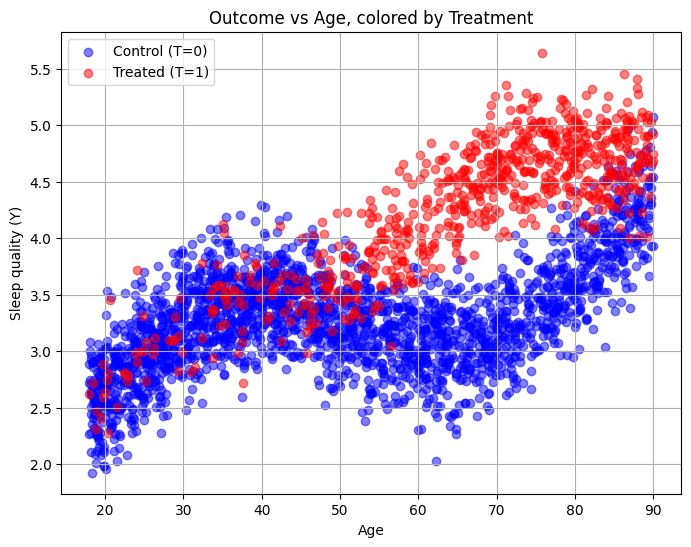

In [5]:
# Visualize Y over age, colored by treatment
plt.figure(figsize=(8, 6))
plt.scatter(df.loc[df["T"] == 0, "age"], df.loc[df["T"] == 0, "Y"], c="blue", alpha=0.5, label="Control (T=0)")
plt.scatter(df.loc[df["T"] == 1, "age"], df.loc[df["T"] == 1, "Y"], c="red", alpha=0.5, label="Treated (T=1)")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Sleep quality (Y)")
plt.title("Outcome vs Age, colored by Treatment")
plt.grid()

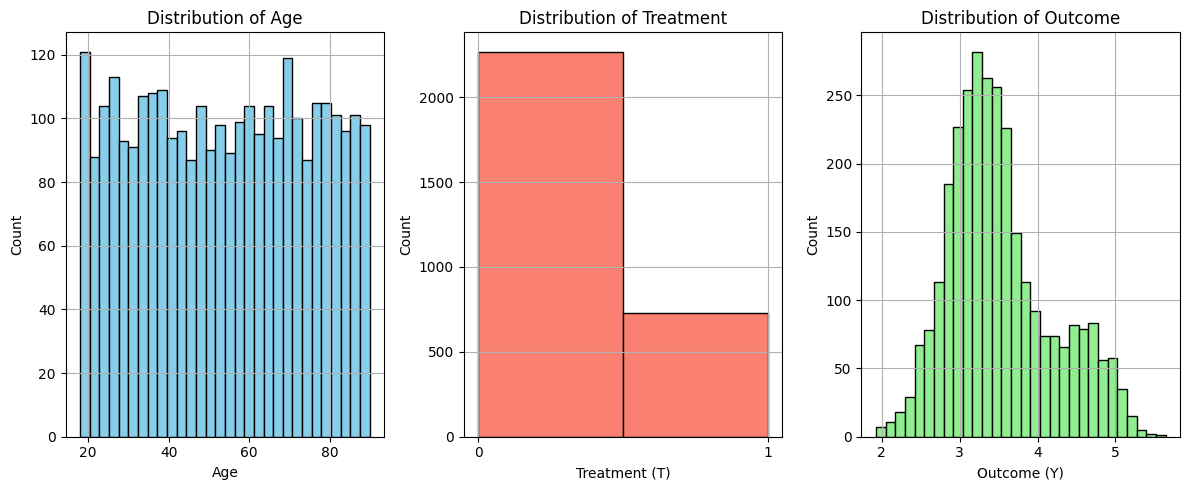

In [6]:
# Visualize the data 
# age
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.hist(df["age"], bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Age")
plt.grid()
# treatment
plt.subplot(1, 3, 2)
plt.hist(df["T"], bins=2, color="salmon", edgecolor="black")
plt.xlabel("Treatment (T)")
plt.ylabel("Count")
plt.title("Distribution of Treatment")
plt.xticks([0, 1])
plt.grid()
# outcome
plt.subplot(1, 3, 3)
plt.hist(df["Y"], bins=30, color="lightgreen", edgecolor="black")
plt.xlabel("Outcome (Y)")
plt.ylabel("Count")
plt.title("Distribution of Outcome")
plt.grid()
plt.tight_layout()

### Train metalearners using random forest models

In [ ]:
# 2) Train / test split
train, test = train_test_split(df, test_size=0.3, random_state=RANDOM_STATE)
X_train = train[["age"]]
X_test = test[["age"]]
T_train = train["T"].values
T_test = test["T"].values
Y_train = train["Y"].values
Y_test = test["Y"].values

regularization_params = {
    "max_depth": 20, # limit depth to avoid overfitting on small data
    "n_estimators": 500, # number of trees in the forest
    "min_samples_leaf": 20, # minimum samples per leaf to avoid overfitting
}

# %%
# 3) S-learner: single model taking treatment as a feature
s_model = RandomForestRegressor(random_state=RANDOM_STATE, **regularization_params)
# Concatenate age and treatment
s_model.fit(np.column_stack([X_train["age"], T_train]), Y_train)

# For test set, predict outcome under T=1 and T=0
X_test_age = X_test["age"].values
X_test_t1 = np.column_stack([X_test_age, np.ones_like(X_test_age)])
X_test_t0 = np.column_stack([X_test_age, np.zeros_like(X_test_age)])

y_pred_t1_s = s_model.predict(X_test_t1)
y_pred_t0_s = s_model.predict(X_test_t0)

cate_s = y_pred_t1_s - y_pred_t0_s

# %%
# 4) T-learner: two separate models trained on treated and control groups
# Model for treated
model_treated = RandomForestRegressor(random_state=RANDOM_STATE, **regularization_params)
model_control = RandomForestRegressor(random_state=RANDOM_STATE, **regularization_params)

train_treated = train[train["T"] == 1]
train_control = train[train["T"] == 0]

# If one group becomes extremely small, regularization or other methods would be needed.
model_treated.fit(train_treated[["age"]], train_treated["Y"])
model_control.fit(train_control[["age"]], train_control["Y"])

# Predict potential outcomes on test set
y_pred1_t = model_treated.predict(X_test)
y_pred0_t = model_control.predict(X_test)
cate_t = y_pred1_t - y_pred0_t

### Evaluate the two approaches based on different metrics

Assess the prediction error on the test set, the predicted ATE, and the functional outputs (the CATE function).

PEHE (S-learner): 0.1381
PEHE (T-learner): 0.1377
ATE true: 0.5793, S: 0.5584, T: 0.5573


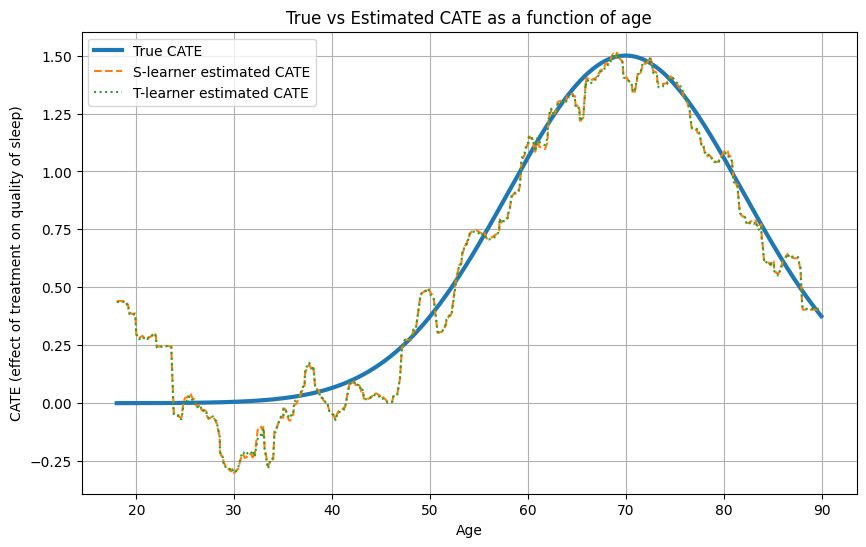

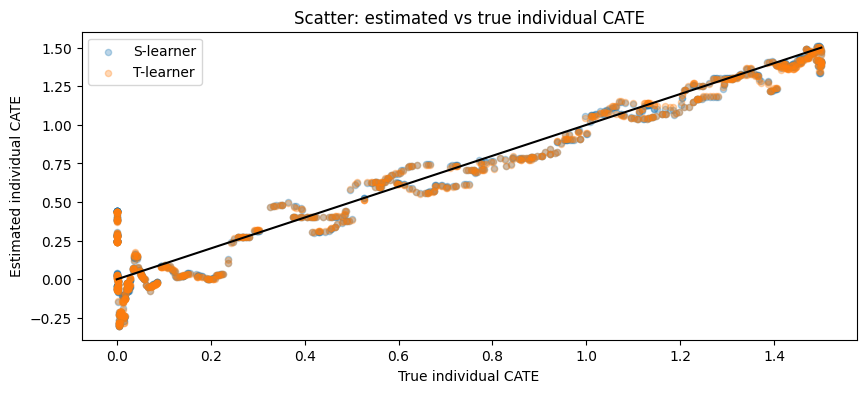


Bin-wise bias (positive = overestimation):
   bin   age_mean  count    bias_s    bias_t
0    1  22.956362    137  0.173027  0.168238
1    2  33.913046    140 -0.125803 -0.123334
2    3  43.629552    136 -0.079329 -0.080842
3    4  54.393301    106 -0.015295 -0.015919
4    5  64.190342    137 -0.020049 -0.019780
5    6  74.432057    119 -0.057861 -0.057987
6    7  84.973132    125 -0.022926 -0.025780


In [9]:

# %%
# 5) Evaluation: compare estimated CATE to true CATE on test set
true_cate_test = test["true_effect"].values

pehe_s = np.sqrt(mean_squared_error(true_cate_test, cate_s))  # root PEHE for S-learner
pehe_t = np.sqrt(mean_squared_error(true_cate_test, cate_t))  # root PEHE for T-learner

# ATE estimates
ate_true = np.mean(true_cate_test)
ate_s = np.mean(cate_s)
ate_t = np.mean(cate_t)

print(f"PEHE (S-learner): {pehe_s:.4f}")
print(f"PEHE (T-learner): {pehe_t:.4f}")
print(f"ATE true: {ate_true:.4f}, S: {ate_s:.4f}, T: {ate_t:.4f}")

# %%
# 6) Visualization
# Sort test points by age for smooth plotting
order = np.argsort(X_test_age)
age_sorted = X_test_age[order]
true_sorted = true_cate_test[order]
cate_s_sorted = cate_s[order]
cate_t_sorted = cate_t[order]

plt.figure(figsize=(10, 6))
plt.plot(age_sorted, true_sorted, label="True CATE", linewidth=3)
plt.plot(age_sorted, cate_s_sorted, label="S-learner estimated CATE", linestyle="--")
plt.plot(age_sorted, cate_t_sorted, label="T-learner estimated CATE", linestyle=":")
plt.xlabel("Age")
plt.ylabel("CATE (effect of treatment on quality of sleep)")
plt.title("True vs Estimated CATE as a function of age")
plt.legend()
plt.grid(True)
plt.show()

# Scatter of individual estimates vs true
plt.figure(figsize=(10, 4))
plt.scatter(true_cate_test, cate_s, alpha=0.3, label="S-learner", s=20)
plt.scatter(true_cate_test, cate_t, alpha=0.3, label="T-learner", s=20)
plt.plot([true_cate_test.min(), true_cate_test.max()], [true_cate_test.min(), true_cate_test.max()], color='k')
plt.xlabel("True individual CATE")
plt.ylabel("Estimated individual CATE")
plt.legend()
plt.title("Scatter: estimated vs true individual CATE")
plt.show()

# %%
# 7) Optional: examine how estimates vary across age bins and compute bin-wise bias
bins = np.linspace(18, 90, 8)
bin_idx = np.digitize(X_test_age, bins)
results = []
for b in range(1, len(bins) + 1):
    mask = bin_idx == b
n_mask = mask.sum() if 'mask' in locals() else 0
for b in range(1, len(bins) + 1):
    mask = bin_idx == b
    if mask.sum() == 0:
        continue
    age_range = (bins[b-1] if b-1 < len(bins) else bins[-1], bins[b-1] if b-1 < len(bins) else bins[-1])
    bias_s = np.mean(cate_s[mask] - true_cate_test[mask])
    bias_t = np.mean(cate_t[mask] - true_cate_test[mask])
    results.append({
        "bin": b,
        "age_mean": X_test_age[mask].mean(),
        "count": mask.sum(),
        "bias_s": bias_s,
        "bias_t": bias_t,
    })

results_df = pd.DataFrame(results)
print("\nBin-wise bias (positive = overestimation):")
print(results_df)

### Discussion

TBW